<a href="https://colab.research.google.com/github/nishuchy/AI-works/blob/main/Unsupervised_Machine_Learning_Unveiling_Hidden_Patterns_in_Data_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Import Libraries

In [2]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')
# Set aesthetic style for plots
sns.set_style("whitegrid")

# Step 2: Load the Dataset
# The dataset is often available as a CSV.
# You might need to upload it to Colab's session storage
# or directly load from a URL if available.
# For simplicity, we'll assume it's in the same directory or provide a direct link if possible.

# As of 2023, the UCI link provides a .csv directly downloadable
# If having issues with direct download, download manually and upload to Colab
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv"
try:
    df = pd.read_csv(url)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}. Please ensure the URL is correct or upload the file manually.")
    # If direct load fails, download the CSV locally and then upload to Colab
    # pd.read_csv('Wholesale customers data.csv')

# Step 3: Initial Exploration (EDA - Part 1)
print("\n--- Dataset Head ---")
print(df.head())

print("\n--- Dataset Info ---")
df.info()

print("\n--- Dataset Description ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

Dataset loaded successfully!

--- Dataset Head ---
   Channel  Region  Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0        2       3  12669  9656     7561     214              2674        1338
1        2       3   7057  9810     9568    1762              3293        1776
2        2       3   6353  8808     7684    2405              3516        7844
3        1       3  13265  1196     4221    6404               507        1788
4        2       3  22615  5410     7198    3915              1777        5185

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-nul

 Data Cleaning, Preprocessing & Wrangling

In [3]:
# Step 1: Drop Channel and Region for initial clustering based on spending habits
# Make a copy to avoid SettingWithCopyWarning if we decide to use original df later
data = df.copy()
data = data.drop(['Channel', 'Region'], axis=1)

print("\n--- Data after dropping Channel and Region ---")
print(data.head())

# Step 2: Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame for better readability (optional during training)
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

print("\n--- Scaled Data Head ---")
print(scaled_df.head())
print("\n--- Scaled Data Description ---")
print(scaled_df.describe())


--- Data after dropping Channel and Region ---
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicassen
0  12669  9656     7561     214              2674        1338
1   7057  9810     9568    1762              3293        1776
2   6353  8808     7684    2405              3516        7844
3  13265  1196     4221    6404               507        1788
4  22615  5410     7198    3915              1777        5185

--- Scaled Data Head ---
      Fresh      Milk   Grocery    Frozen  Detergents_Paper  Delicassen
0  0.052933  0.523568 -0.041115 -0.589367         -0.043569   -0.066339
1 -0.391302  0.544458  0.170318 -0.270136          0.086407    0.089151
2 -0.447029  0.408538 -0.028157 -0.137536          0.133232    2.243293
3  0.100111 -0.624020 -0.392977  0.687144         -0.498588    0.093411
4  0.840239 -0.052396 -0.079356  0.173859         -0.231918    1.299347

--- Scaled Data Description ---
              Fresh        Milk       Grocery        Frozen  Detergents_Paper  \
count  4

Feature Engineering (Conceptual)

Exploratory Data Analysis (EDA) - Deeper Dive

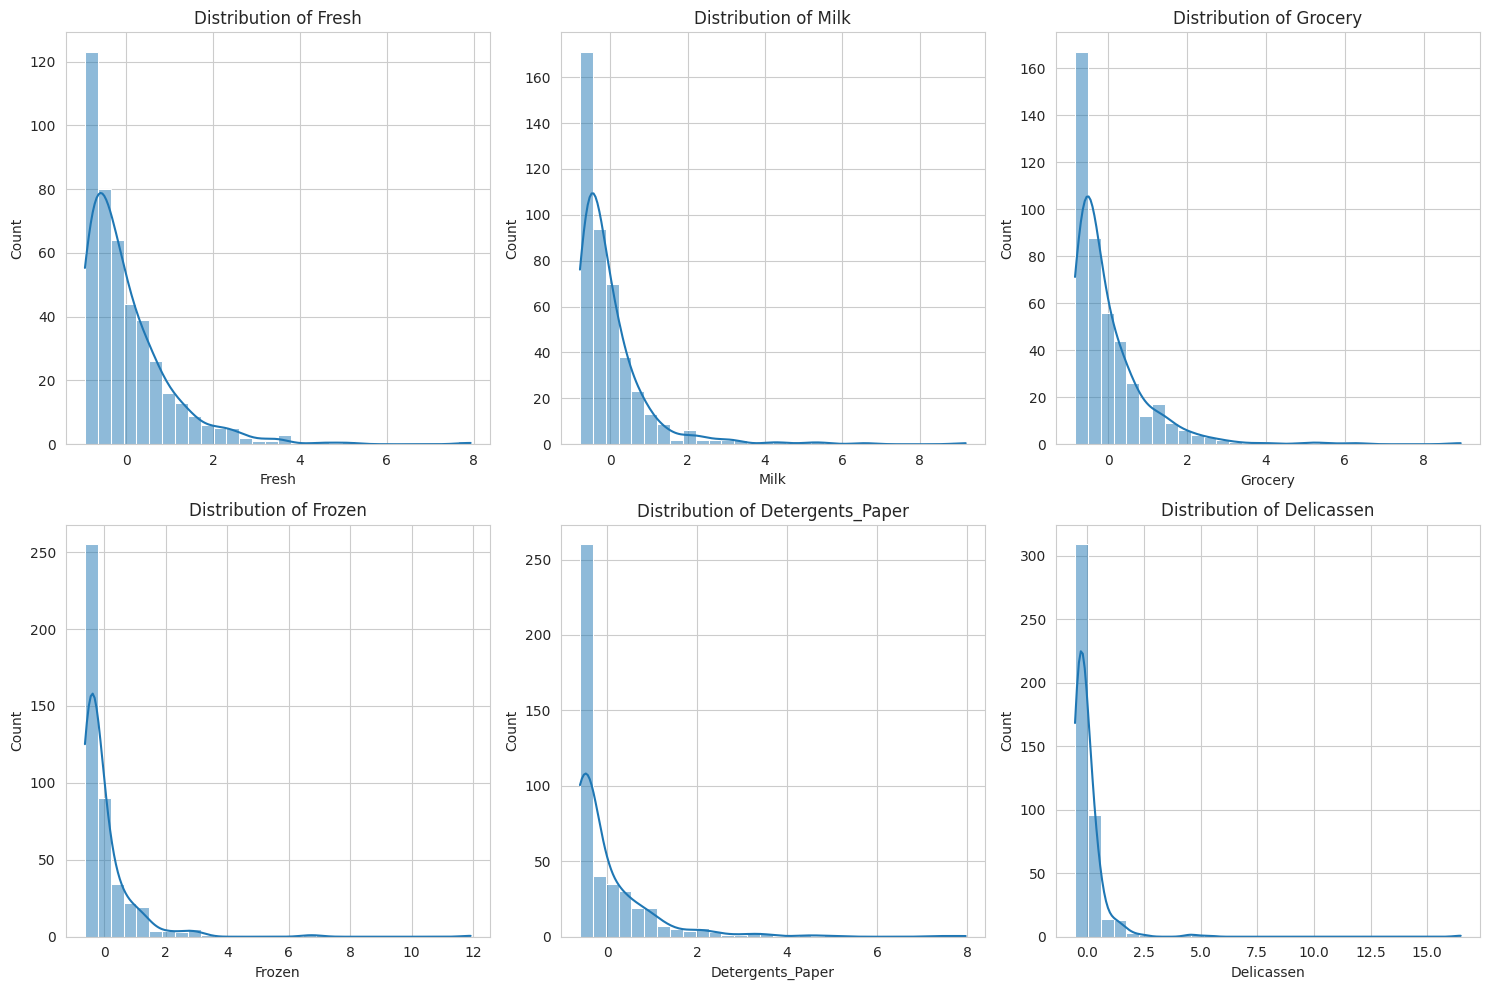

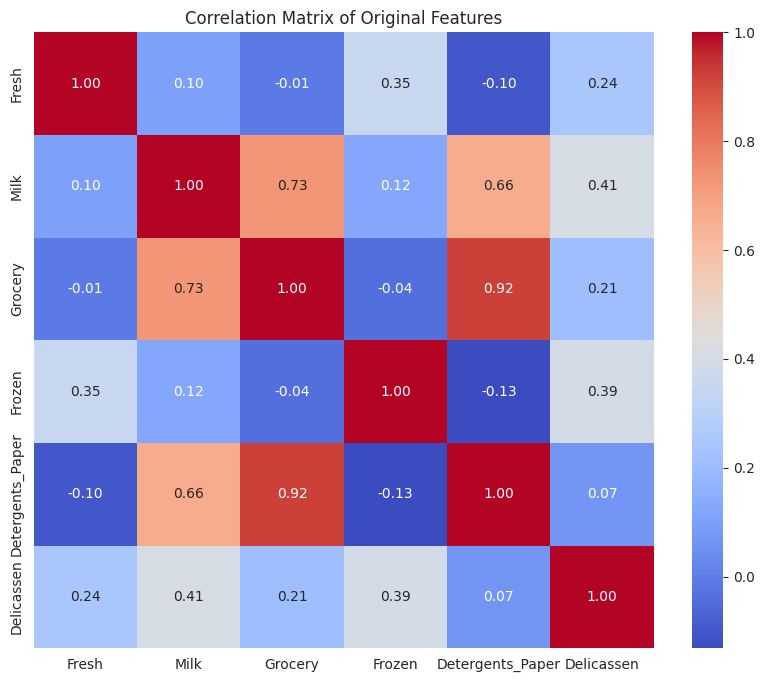

In [6]:
# Step 1: Distribution of features (after scaling)
plt.figure(figsize=(15, 10))
for i, col in enumerate(scaled_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(scaled_df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Step 2: Correlation Matrix (before and after scaling - scaling doesn't change correlation)
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Original Features')
plt.show()

# Observations from EDA:
# - Some features like 'Detergents_Paper' and 'Grocery' are highly correlated, which makes sense.
# - The distributions, though standardized, might still show skewness. Clustering algorithms implicitly handle this
#   by finding natural groupings, but techniques like log transformations could be considered if data is heavily skewed
#   and specific distribution assumptions are required for other models (not strictly for KMeans/Agglomerative).

K-Means Clustering


--- K-Means Clustering ---


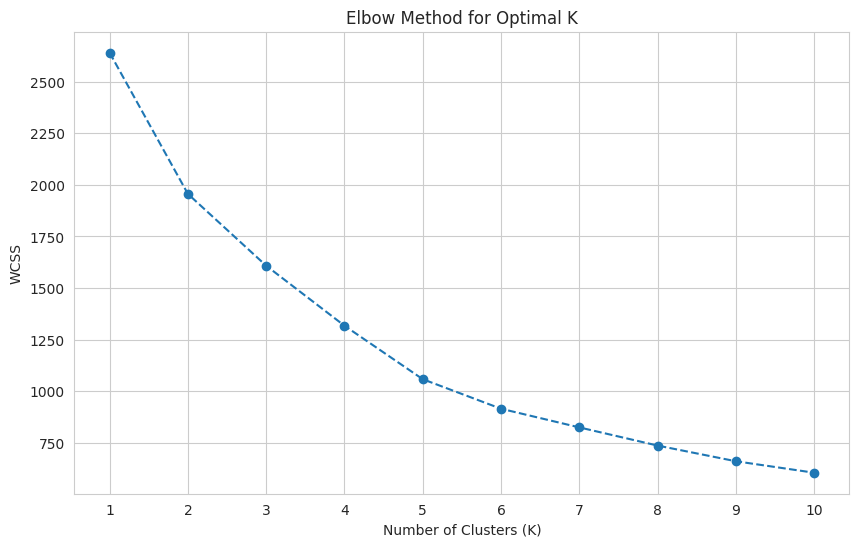

K-Means Silhouette Score (k=3): 0.548

--- K-Means Cluster Centroids (Original Scale) ---
                Fresh          Milk       Grocery        Frozen  \
Cluster                                                           
0        10440.933333  19386.422222  28656.088889   2190.244444   
1        12062.913486   4115.099237   5534.966921   2940.676845   
2        34782.000000  30367.000000  16898.000000  48701.500000   

         Detergents_Paper    Delicassen  
Cluster                                  
0            13327.800000   2374.200000  
1             1696.170483   1299.114504  
2              755.500000  26776.000000  


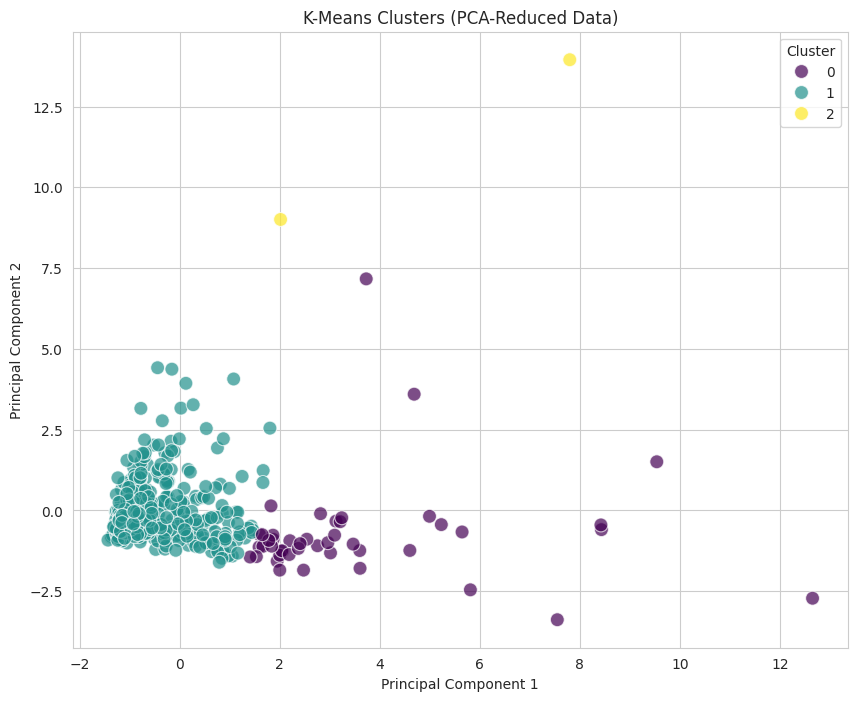

In [7]:
print("\n--- K-Means Clustering ---")

# Step 8.1.1: Determine optimal number of clusters (k) using Elbow Method
wcss = [] # Within-Cluster Sum of Squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_) # inertia_ is the WCSS

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, 11))
plt.show()

# From the elbow plot, often k=3 or k=4 seems like a good elbow point.
# Let's choose k=3 for demonstration.

n_clusters_kmeans = 3 # Chosen based on Elbow Method
# Step 8.1.2: Train K-Means Model
kmeans_model = KMeans(n_clusters=n_clusters_kmeans, init='k-means++', max_iter=300, n_init=10,
random_state=42)
kmeans_labels = kmeans_model.fit_predict(scaled_data)

# Step 8.1.3: Evaluate K-Means
silhouette_avg_kmeans = silhouette_score(scaled_data, kmeans_labels)
print(f"K-Means Silhouette Score (k={n_clusters_kmeans}): {silhouette_avg_kmeans:.3f}")

# Step 8.1.4: Add cluster labels to the original (unscaled) DataFrame
df_kmeans = df.copy()
df_kmeans['KMeans_Cluster'] = kmeans_labels

# Step 8.1.5: Analyze Cluster Centroids (Mean values for each feature in each cluster)
kmeans_cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans_model.cluster_centers_),
columns=data.columns)
kmeans_cluster_centers['Cluster'] = range(n_clusters_kmeans)
kmeans_cluster_centers = kmeans_cluster_centers.set_index('Cluster')
print("\n--- K-Means Cluster Centroids (Original Scale) ---")
print(kmeans_cluster_centers)

# Visualization of K-Means Clusters (using PCA for 2D representation)
# Apply PCA for dimensionality reduction for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['KMeans_Cluster'] = kmeans_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=pca_df, palette='viridis', s=100,
alpha=0.7)
plt.title('K-Means Clusters (PCA-Reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Hierarchical Clustering (Agglomerative)


--- Hierarchical Clustering ---


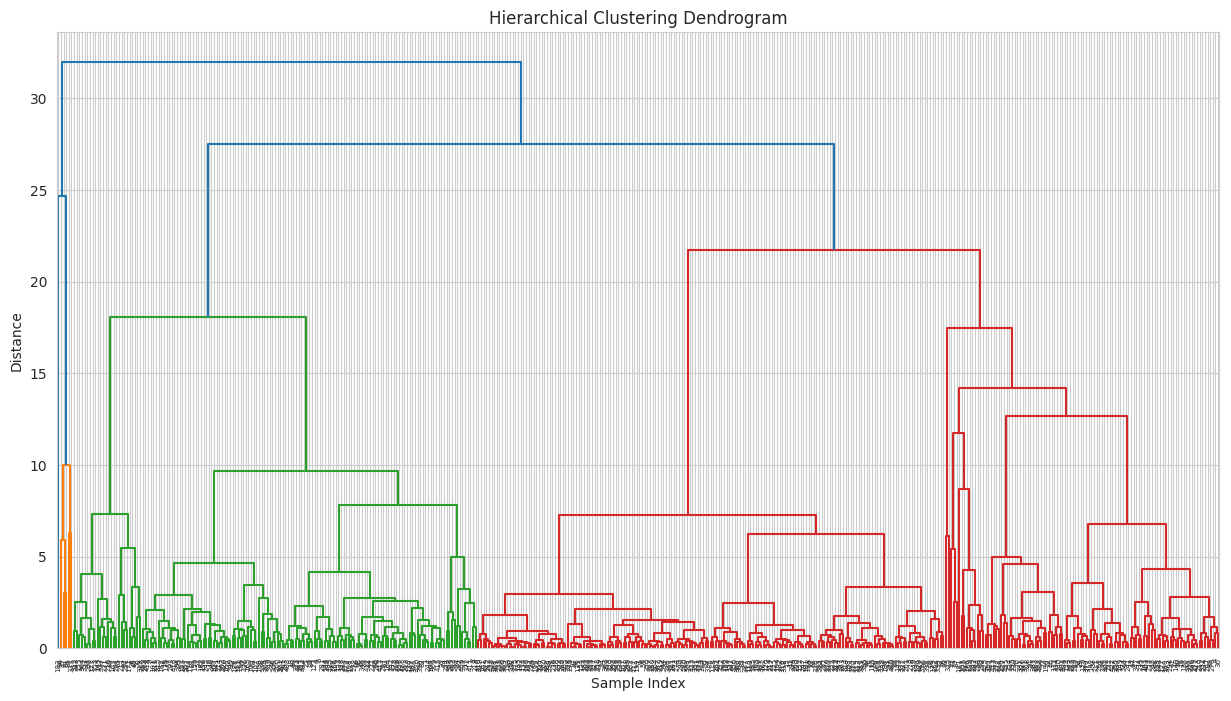

Hierarchical Clustering Silhouette Score (k=3): 0.265

--- Hierarchical Cluster Centroids (Original Scale) ---
                    Fresh          Milk       Grocery       Frozen  \
Agg_Cluster                                                          
0            27477.000000  43542.166667  54588.500000  8285.666667   
1            15048.932384   3017.298932   3791.761566  3837.316726   
2             5794.241830   9419.888889  13761.738562  1461.764706   

             Detergents_Paper    Delicassen  
Agg_Cluster                                  
0                25018.333333  10247.833333  
1                  758.007117   1309.900356  
2                 5913.379085   1577.607843  


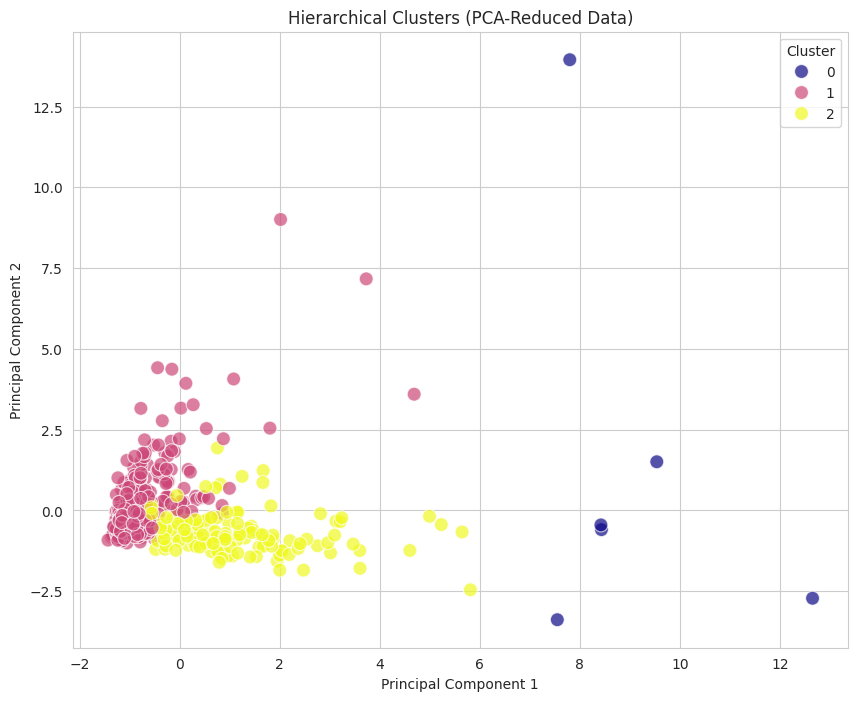

In [9]:
# --- Hierarchical Clustering (Agglomerative) ---

print("\n--- Hierarchical Clustering ---")

# Step 8.2.1: Create Dendrogram to help choose number of clusters
# This can be computationally intensive for very large datasets
plt.figure(figsize=(15, 8))
dendrogram(linkage(scaled_data, method='ward')) # 'ward' minimizes variance within clusters
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()
# From the dendrogram, cutting at a certain height (e.g., around 10-15) suggests 3-4 clusters.
# Let's use 3 clusters for consistency with K-Means.
n_clusters_hierarchical = 3

# Step 8.2.2: Train Agglomerative Clustering Model
agg_model = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, linkage='ward')
agg_labels = agg_model.fit_predict(scaled_data)

# Step 8.2.3: Evaluate Hierarchical Clustering
silhouette_avg_agg = silhouette_score(scaled_data, agg_labels)
print(f"Hierarchical Clustering Silhouette Score (k={n_clusters_hierarchical}): {silhouette_avg_agg:.3f}")

# Step 8.2.4: Add cluster labels to the original DataFrame
df_agg = df.copy()
df_agg['Agg_Cluster'] = agg_labels

# Step 8.2.5: Analyze Cluster Centroids (Mean values for each feature in each cluster)
# For Agglomerative, there are no explicit centroids, so we calculate means for each cluster
agg_cluster_centers = df_agg.groupby('Agg_Cluster')[data.columns].mean()
print("\n--- Hierarchical Cluster Centroids (Original Scale) ---")
print(agg_cluster_centers)

# Visualization of Hierarchical Clusters (using PCA for 2D representation)
pca_df['Agg_Cluster'] = agg_labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Agg_Cluster', data=pca_df, palette='plasma', s=100,
alpha=0.7)
plt.title('Hierarchical Clusters (PCA-Reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


--- DBSCAN Clustering ---
DBSCAN found 2 clusters and 174 noise points.
DBSCAN Silhouette Score: 0.521

--- DBSCAN Cluster Centroids (Original Scale) ---
                       Fresh          Milk       Grocery       Frozen  \
DBSCAN_Cluster                                                          
-1              15608.988506  10000.408046  13693.298851  4786.275862   
 0               9030.398467   3077.318008   4234.061303  1963.432950   

                Detergents_Paper   Delicassen  
DBSCAN_Cluster                                 
-1                   5291.373563  2510.781609  
 0                   1322.134100   881.773946  


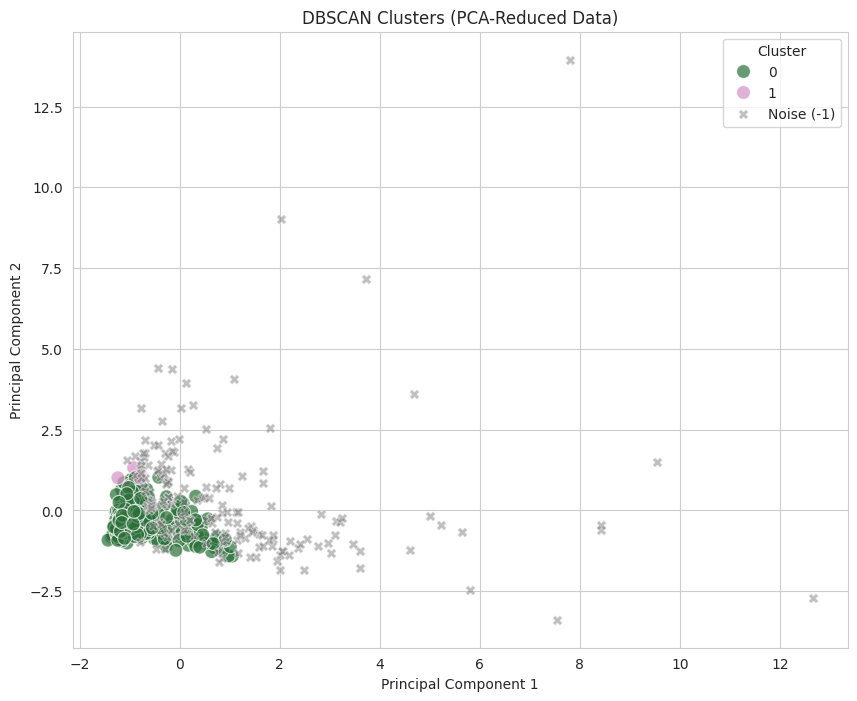

In [10]:
# --- DBSCAN Clustering ---

print("\n--- DBSCAN Clustering ---")

# Step 8.3.1: Determine optimal eps (using k-distance graph - typically k=min_samples)
# For demonstration, we'll try some values, but in practice, you'd plot distances
# from sklearn.neighbors import NearestNeighbors
# neigh = NearestNeighbors(n_neighbors=2) # find distance to 2nd nearest neighbor (min_samples 1)
# nbrs = neigh.fit(scaled_data)
# distances, indices = nbrs.kneighbors(scaled_data)
# distances = np.sort(distances[:, 1], axis=0) # Sort distances to 2nd nearest neighbor
# plt.figure(figsize=(10, 6))
# plt.plot(distances)
# plt.title('K-Distance Graph for DBSCAN (min_samples=2)')
# plt.xlabel('Data Points sorted by distance')
# plt.ylabel('Distance')
# plt.show()
# Look for the "elbow" in this plot to determine a good 'eps' value.

# Let's try some common values for DBSCAN hyperparameters for this data
# These are often found through experimentation or the k-distance plot
eps_dbscan = 0.5 # A common starting point for scaled data
min_samples_dbscan = 5 # Standard default

# Step 8.3.2: Train DBSCAN Model
dbscan_model = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
dbscan_labels = dbscan_model.fit_predict(scaled_data)

# Number of clusters found (excluding noise, label -1)
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"DBSCAN found {n_clusters_dbscan} clusters and {n_noise_dbscan} noise points.")

# Step 8.3.3: Evaluate DBSCAN (Silhouette Score does not work well if many noise points)
# Silhouette score excludes noise points (-1 label)
if n_clusters_dbscan > 1: # Silhouette score requires at least 2 clusters
    silhouette_avg_dbscan = silhouette_score(scaled_data[dbscan_labels != -1],
dbscan_labels[dbscan_labels != -1])
    print(f"DBSCAN Silhouette Score: {silhouette_avg_dbscan:.3f}")
else:
    print("DBSCAN did not find enough clusters (or found only noise) for Silhouette Score.")

# Step 8.3.4: Add cluster labels to the original DataFrame
df_dbscan = df.copy()
df_dbscan['DBSCAN_Cluster'] = dbscan_labels

# Analyze Cluster Centroids (Mean values for each feature in each cluster) - excluding noise
if n_clusters_dbscan > 0:
    dbscan_cluster_centers = df_dbscan[df_dbscan['DBSCAN_Cluster'] !=
1].groupby('DBSCAN_Cluster')[data.columns].mean()
    print("\n--- DBSCAN Cluster Centroids (Original Scale) ---")
    print(dbscan_cluster_centers)
else:
    print("\nNo clusters found by DBSCAN to calculate centroids.")


# Visualization of DBSCAN Clusters (using PCA for 2D representation)
pca_df['DBSCAN_Cluster'] = dbscan_labels

plt.figure(figsize=(10, 8))
# Plot noise points in a distinct color/marker
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=pca_df[pca_df['DBSCAN_Cluster'] != -1],
                palette='cubehelix', s=100, alpha=0.7, legend='full')
sns.scatterplot(x='PC1', y='PC2', data=pca_df[pca_df['DBSCAN_Cluster'] == -1],
                color='gray', marker='X', s=50, label='Noise (-1)', alpha=0.5)
plt.title('DBSCAN Clusters (PCA-Reduced Data)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

 Principal Component Analysis (PCA) - Dimensionality Reduction



--- Principal Component Analysis (PCA) ---


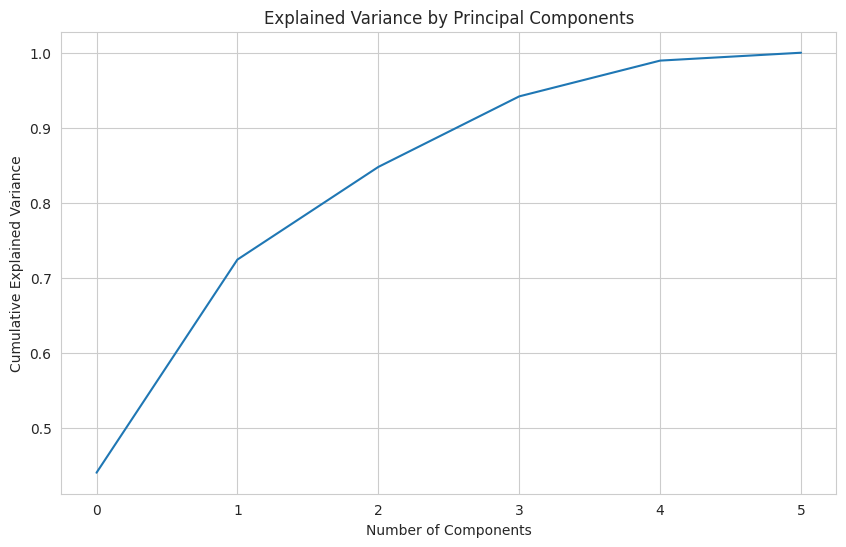


Explained Variance Ratio for 2 components:
[0.44082893 0.283764  ]
Total Explained Variance by 2 components: 0.725
K-Means Silhouette Score on PCA-reduced data (2 components): 0.627


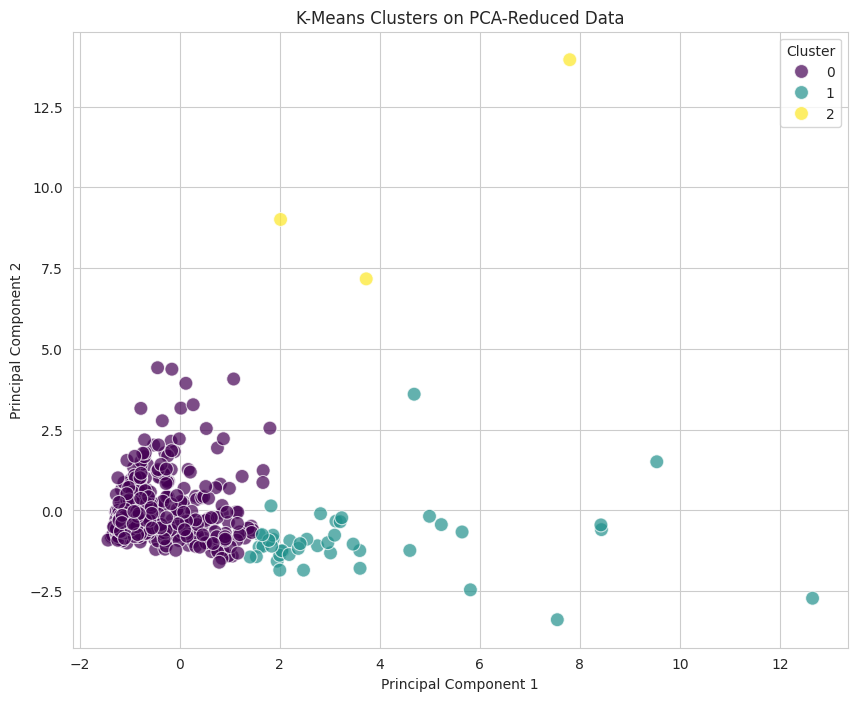

In [15]:
# --- Principal Component Analysis (PCA) ---

print("\n--- Principal Component Analysis (PCA) ---")

# Step 8.4.1: Fit PCA to the scaled data
# Let's assess how many components to keep
pca_full = PCA()
pca_full.fit(scaled_data)

# Step 8.4.2: Plot Explained Variance Ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Based on the plot, 2-3 components explain a good portion of the variance (e.g., 2 components explain ~60%)
n_components_pca = 2 # For visualization and simplicity

pca = PCA(n_components=n_components_pca)
principal_components = pca.fit_transform(scaled_data)

print(f"\nExplained Variance Ratio for {n_components_pca} components:")
print(pca.explained_variance_ratio_)
print(f"Total Explained Variance by {n_components_pca} components: {pca.explained_variance_ratio_.sum():.3f}")

# The principal components themselves are not "clusters" but new features.
# You can then apply clustering algorithms on these reduced dimensions.
# For example, let's re-run K-Means on PCA-reduced data for comparison (optional)
kmeans_pca = KMeans(n_clusters=n_clusters_kmeans, init='k-means++', max_iter=300, n_init=10,
random_state=42)
kmeans_pca_labels = kmeans_pca.fit_predict(principal_components)

silhouette_avg_kmeans_pca = silhouette_score(principal_components, kmeans_pca_labels)
print(f"K-Means Silhouette Score on PCA-reduced data ({n_components_pca} components): {silhouette_avg_kmeans_pca:.3f}")

# Visualization of PCA-reduced data itself (coloring by K-Means labels from PCA)
pca_df_final = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in
range(n_components_pca)])
pca_df_final['KMeans_Cluster_on_PCA'] = kmeans_pca_labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster_on_PCA', data=pca_df_final,
palette='viridis', s=100, alpha=0.7)
plt.title('K-Means Clusters on PCA-Reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


Performance Metrics & Evaluation

In [16]:
print("\n--- Performance Metrics Summary ---")
print(f"K-Means Silhouette Score (k={n_clusters_kmeans}): {silhouette_avg_kmeans:.3f}")
print(f"Hierarchical Clustering Silhouette Score (k={n_clusters_hierarchical}): {silhouette_avg_agg:.3f}")
# DBSCAN: If many noise points (-1), Silhouette Score might be lower or not representative
# Only calculate if more than one cluster identified
if n_clusters_dbscan > 1:
 print(f"DBSCAN Silhouette Score: {silhouette_avg_dbscan:.3f} (Note: Excludes noise points)")
else:
 print("DBSCAN did not find enough clusters for meaningful Silhouette Score.")
# K-Means on PCA data for comparison
print(f"K-Means Silhouette Score on PCA-reduced data: {silhouette_avg_kmeans_pca:.3f}")


--- Performance Metrics Summary ---
K-Means Silhouette Score (k=3): 0.548
Hierarchical Clustering Silhouette Score (k=3): 0.265
DBSCAN Silhouette Score: 0.521 (Note: Excludes noise points)
K-Means Silhouette Score on PCA-reduced data: 0.627
